# cricWAR Financial Valuation Analysis (IPL 2025)

This notebook implements the "Moneyball" metrics for IPL 2025 players, comparing their auction price to their on-field performance (WAR).

## Metrics
1. **ROI Basic**: Wins per 1% of Salary Cap.
2. **VOPE (Value Over Price Expectation)**: Performance vs. expected performance for that price tag (Polynomial Regression).
3. **VOMAM (Value Over Market Adjusted Model)**: Performance vs. expected performance adjusting for Price, Role, and Overseas status.

## Validation
Each step includes `assert` statements to verify data integrity and calculation correctness.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

# Constants
TEAM_PURSE_2025 = 120.0  # Crores
PROJECT_ROOT = Path('..')

## 1. Data Loading & Preparation

In [2]:
def load_data():
    # Load mapped data
    war_price_file = PROJECT_ROOT / 'results' / '11_war_vs_price' / 'war_vs_price_full.csv'
    df = pd.read_csv(war_price_file)
    
    # Filter mapped players
    df = df[df['match_type'] != 'none'].copy()
    
    # Load metadata
    meta_file = PROJECT_ROOT / 'data' / 'player_metadata.csv'
    metadata = pd.read_csv(meta_file)
    
    # Merge
    df = df.merge(metadata[['player_name', 'country', 'role_category']], 
                  left_on='cricwar_name', right_on='player_name', how='left')
    
    # Feature Engineering
    df['price_norm'] = (df['price_cr'] / TEAM_PURSE_2025) * 100
    df['is_overseas'] = df['country'].apply(lambda x: 0 if str(x).lower() in ['india', 'ind'] else 1)
    df['role_category'] = df['role_category'].fillna('Unknown')
    
    return df

df = load_data()

# --- TESTS ---
print("Running Data Tests...")
assert len(df) > 0, "Dataframe is empty!"
assert 'total_WAR' in df.columns, "Missing total_WAR column"
assert 'price_cr' in df.columns, "Missing price_cr column"
assert df['price_norm'].max() <= 100, "Price norm > 100%"
assert df['is_overseas'].isin([0, 1]).all(), "Invalid is_overseas values"
print(f"✓ Data Loaded: {len(df)} players")
df.head()

Running Data Tests...
✓ Data Loaded: 113 players


,price_name,cricwar_name,team,price_cr,total_WAR,batting_WAR,bowling_WAR,match_type,war_per_crore,price_per_1_war,player_name,country,role_category,price_norm,is_overseas
0,Matheesha Pathirana,M Pathirana,Chennai Super Kings,13.0,0.953810,0.000000,0.953810,exact,0.073370,13.629543,M Pathirana,Sri Lanka,Pacer,10.833333,1
1,MS Dhoni,MS Dhoni,Chennai Super Kings,4.0,0.237593,0.237593,0.000000,exact,0.059398,16.835510,MS Dhoni,India,Wicketkeeper,3.333333,0
2,Noor Ahmad,Noor Ahmad,Chennai Super Kings,10.0,0.946171,-0.064875,1.011046,exact,0.094617,10.568919,Noor Ahmad,Afghanistan,Spinner,8.333333,1
3,Rachin Ravindra,R Ravindra,Chennai Super Kings,4.0,0.519677,0.519677,0.000000,exact,0.129919,7.697087,R Ravindra,New Zealand,Allrounder,3.333333,1
4,Rahul Tripathi,RA Tripathi,Chennai Super Kings,3.4,0.031237,0.031237,0.000000,fuzzy,0.009187,NaN,RA Tripathi,India,Top-order Batter,2.833333,0


## 2. Metric 1: ROI Basic
**Wins per 1% of Salary Cap**

In [3]:
def calculate_roi(df):
    # Floor price to avoid division by zero
    min_price_norm = 0.05
    df['price_norm_adj'] = df['price_norm'].clip(lower=min_price_norm)
    df['roi_basic'] = df['total_WAR'] / df['price_norm_adj']
    return df

df = calculate_roi(df)

# --- TESTS ---
print("Running ROI Tests...")
assert 'roi_basic' in df.columns
assert not df['roi_basic'].isna().any(), "NaN values in ROI"
# Check a known high performer
top_roi = df.sort_values('roi_basic', ascending=False).iloc[0]
print(f"Top ROI: {top_roi['price_name']} ({top_roi['roi_basic']:.2f} wins/1% cap)")
print("✓ ROI Calculated")

Running ROI Tests...
Top ROI: Aniket Verma (2.48 wins/1% cap)
✓ ROI Calculated


## 3. Metric 2: VOPE Simple
**Value Over Price Expectation** (Polynomial Regression)

In [4]:
def calculate_vope(df):
    X = df[['price_norm']].values
    y = df['total_WAR'].values
    
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    model = LinearRegression()
    model.fit(X_poly, y)
    
    df['xWAR_price_only'] = model.predict(X_poly)
    df['vope_simple'] = df['total_WAR'] - df['xWAR_price_only']
    
    return df, model

df, vope_model = calculate_vope(df)

# --- TESTS ---
print("Running VOPE Tests...")
assert 'vope_simple' in df.columns
# Residuals should sum to approx zero
assert abs(df['vope_simple'].mean()) < 1e-10, "Residuals do not mean-center to 0"
print("✓ VOPE Calculated")

Running VOPE Tests...
✓ VOPE Calculated


## 4. Metric 3: VOMAM
**Value Over Market Adjusted Model** (Multivariate Regression)

In [5]:
def calculate_vomam(df):
    role_dummies = pd.get_dummies(df['role_category'], prefix='role', drop_first=True, dtype=int)
    
    X = df[['price_norm', 'is_overseas']]
    X = pd.concat([X, role_dummies], axis=1)
    X = sm.add_constant(X)
    y = df['total_WAR']
    
    model = sm.OLS(y, X).fit()
    
    df['xWAR_market_adj'] = model.predict(X)
    df['vomam_score'] = df['total_WAR'] - df['xWAR_market_adj']
    
    return df, model

df, vomam_model = calculate_vomam(df)

# --- TESTS ---
print("Running VOMAM Tests...")
assert 'vomam_score' in df.columns
print("✓ VOMAM Calculated")
print(vomam_model.summary())

Running VOMAM Tests...
✓ VOMAM Calculated
                            OLS Regression Results                            
Dep. Variable:              total_WAR   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     12.18
Date:                Wed, 26 Nov 2025   Prob (F-statistic):           2.58e-11
Time:                        16:37:44   Log-Likelihood:                -36.248
No. Observations:                 113   AIC:                             88.50
Df Residuals:                     105   BIC:                             110.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

## 5. Visualizations

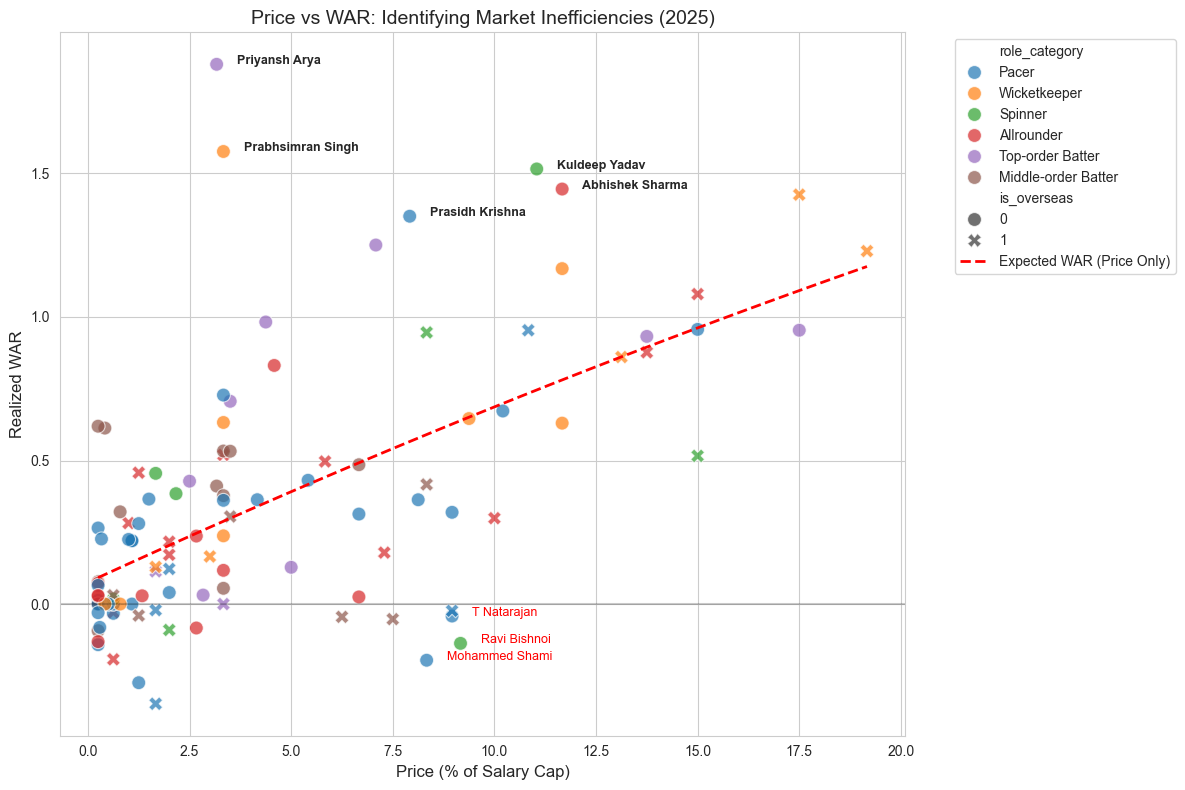

In [6]:
plt.figure(figsize=(12, 8))

# Scatter plot
sns.scatterplot(data=df, x='price_norm', y='total_WAR', hue='role_category', style='is_overseas', s=100, alpha=0.7)

# Regression Curve (VOPE)
x_range = np.linspace(df['price_norm'].min(), df['price_norm'].max(), 100).reshape(-1, 1)
poly = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly.fit_transform(x_range)

# Re-fit simple model for plotting
simple_model = LinearRegression()
simple_model.fit(poly.fit_transform(df[['price_norm']]), df['total_WAR'])
y_pred = simple_model.predict(x_poly)

plt.plot(x_range, y_pred, color='red', linestyle='--', linewidth=2, label='Expected WAR (Price Only)')

# Label top outliers
top_steals = df.nlargest(5, 'vomam_score')
for _, row in top_steals.iterrows():
    plt.text(row['price_norm']+0.5, row['total_WAR'], row['price_name'], fontsize=9, fontweight='bold')

top_overpays = df.nsmallest(3, 'vomam_score')
for _, row in top_overpays.iterrows():
    plt.text(row['price_norm']+0.5, row['total_WAR'], row['price_name'], fontsize=9, color='red')

plt.title('Price vs WAR: Identifying Market Inefficiencies (2025)', fontsize=14)
plt.xlabel('Price (% of Salary Cap)', fontsize=12)
plt.ylabel('Realized WAR', fontsize=12)
plt.axhline(0, color='black', alpha=0.2)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 6. Top Value Picks (The "Moneyball" List)

In [7]:
cols = ['price_name', 'team', 'price_cr', 'total_WAR', 'xWAR_market_adj', 'vomam_score']
print("TOP 10 STEALS (Highest VOMAM):")
display(df[cols].nlargest(10, 'vomam_score'))

print("\nTOP 10 OVERPAYS (Lowest VOMAM):")
display(df[cols].nsmallest(10, 'vomam_score'))

TOP 10 STEALS (Highest VOMAM):


,price_name,team,price_cr,total_WAR,xWAR_market_adj,vomam_score
82,Priyansh Arya,Punjab Kings,3.80,1.880232,0.545897,1.334336
73,Prabhsimran Singh,Punjab Kings,4.00,1.576502,0.446706,1.129795
31,Prasidh Krishna,Gujarat Titans,9.50,1.350993,0.490381,0.860612
11,Kuldeep Yadav,Delhi Capitals,13.25,1.515582,0.782126,0.733455
102,Abhishek Sharma,Sunrisers Hyderabad,14.00,1.445688,0.828882,0.616805
86,Sandeep Sharma,Rajasthan Royals,4.00,0.727967,0.220361,0.507606
2,Noor Ahmad,Chennai Super Kings,10.00,0.946171,0.443646,0.502524
25,Sai Sudharsan,Gujarat Titans,8.50,1.250655,0.776641,0.474014
0,Matheesha Pathirana,Chennai Super Kings,13.00,0.953810,0.483289,0.470522
111,Aniket Verma,Sunrisers Hyderabad,0.30,0.619499,0.162571,0.456928



TOP 10 OVERPAYS (Lowest VOMAM):


,price_name,team,price_cr,total_WAR,xWAR_market_adj,vomam_score
54,Ravi Bishnoi,Lucknow Super Giants,11.00,-0.136968,0.671664,-0.808632
105,Mohammed Shami,Sunrisers Hyderabad,10.00,-0.195765,0.514928,-0.710693
15,T Natarajan,Delhi Capitals,10.75,-0.041740,0.551749,-0.593490
103,Nitish Kumar Reddy,Sunrisers Hyderabad,6.00,0.128029,0.653905,-0.525876
58,Akash Deep,Lucknow Super Giants,8.00,0.024676,0.534315,-0.509639
4,Rahul Tripathi,Chennai Super Kings,3.40,0.031237,0.526259,-0.495022
16,Jake Fraser-McGurk,Delhi Capitals,9.00,-0.052557,0.410770,-0.463328
93,Virat Kohli,Royal Challengers Bengaluru,21.00,0.953871,1.390322,-0.436451
30,Kagiso Rabada,Gujarat Titans,10.75,-0.023656,0.372826,-0.396482
106,Abhinav Manohar,Sunrisers Hyderabad,3.20,-0.083492,0.298662,-0.382154
